In [26]:
!pip -q install kagglehub prophet tensorflow scikit-learn matplotlib seaborn pandas pyarrow

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (12, 4)
pd.set_option("display.max_columns", 50)
np.random.seed(42)

In [28]:
import kagglehub

path = kagglehub.dataset_download("guillemservera/global-daily-climate-data")
print("Caminho local do dataset:", path)

DATA_LINK = "https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data"
print("Kaggle:", DATA_LINK)

Using Colab cache for faster access to the 'global-daily-climate-data' dataset.
Caminho local do dataset: /kaggle/input/global-daily-climate-data
Kaggle: https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data


In [29]:
df = pd.read_parquet(f"{path}/daily_weather.parquet")
print(df.columns)
df.head()

Index(['station_id', 'city_name', 'date', 'season', 'avg_temp_c', 'min_temp_c',
       'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh', 'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa',
       'sunshine_total_min'],
      dtype='object')


,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# 1) Filtrar São Paulo (robusto a acento/case)
mask_sp = df['city_name'].str.contains(r"S[ãa]o Paulo", case=False, regex=True, na=False)
sp_raw = df.loc[mask_sp, ['date', 'avg_temp_c']].copy()

# 2) Datas e ordenação
sp_raw['date'] = pd.to_datetime(sp_raw['date'])
sp_raw = sp_raw.sort_values('date')

# 3) Consolidar por dia (múltiplas estações -> média)
sp_daily = (sp_raw.dropna(subset=['avg_temp_c'])
                    .groupby('date', as_index=False)['avg_temp_c']
                    .mean()
                    .sort_values('date')
                    .set_index('date'))

# 4) Garantir frequência diária contínua e interpolar lacunas
sp_daily = sp_daily.asfreq('D')
sp_daily['avg_temp_c'] = sp_daily['avg_temp_c'].interpolate(method='time', limit_direction='both')

print("Faltantes após interpolação:", sp_daily['avg_temp_c'].isna().sum())
print("Período:", sp_daily.index.min(), "→", sp_daily.index.max())
sp_daily.head()

Faltantes após interpolação: 0
Período: 1973-01-01 00:00:00 → 2023-09-05 00:00:00


,avg_temp_c
date,
1973-01-01,22.9
1973-01-02,24.2
1973-01-03,24.7
1973-01-04,23.2
1973-01-05,23.2


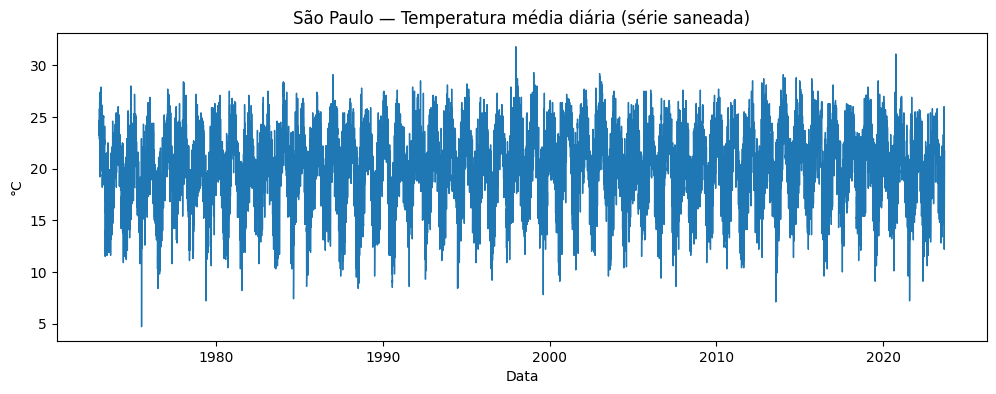

In [31]:
sns.lineplot(x=sp_daily.index, y=sp_daily['avg_temp_c'], linewidth=1.0)
plt.title("São Paulo — Temperatura média diária (série saneada)")
plt.xlabel("Data"); plt.ylabel("°C"); plt.show()

In [32]:
split_idx = int(len(sp_daily) * 0.8)
train = sp_daily.iloc[:split_idx].copy()
test  = sp_daily.iloc[split_idx:].copy()

print(f"Tamanho treino: {len(train)} | teste: {len(test)}")
print("Treino:", train.index.min(), "→", train.index.max())
print("Teste :", test.index.min(),  "→", test.index.max())

Tamanho treino: 14808 | teste: 3702
Treino: 1973-01-01 00:00:00 → 2013-07-17 00:00:00
Teste : 2013-07-18 00:00:00 → 2023-09-05 00:00:00


In [33]:
from prophet import Prophet

prophet_df = train.reset_index().rename(columns={'date':'ds', 'avg_temp_c':'y'})
m_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
m_prophet.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5mc4ka7p/ey6qg22_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5mc4ka7p/04g8op8h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3294', 'data', 'file=/tmp/tmp5mc4ka7p/ey6qg22_.json', 'init=/tmp/tmp5mc4ka7p/04g8op8h.json', 'output', 'file=/tmp/tmp5mc4ka7p/prophet_model2_svwv38/prophet_model-20251005192537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:25:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


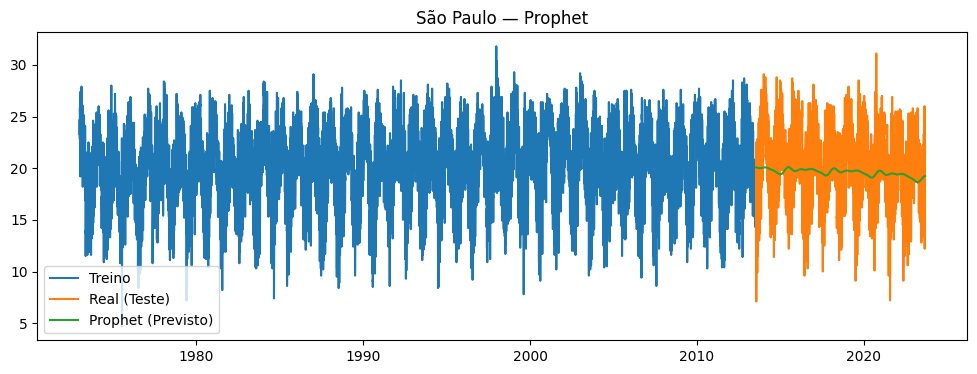

In [34]:
future = test.reset_index().rename(columns={'date':'ds'})
fcst = m_prophet.predict(future)

prophet_res = test.copy()
prophet_res['yhat'] = fcst['yhat'].values

plt.plot(train.index, train['avg_temp_c'], label="Treino")
plt.plot(test.index,  test['avg_temp_c'],  label="Real (Teste)")
plt.plot(prophet_res.index, prophet_res['yhat'], label="Prophet (Previsto)")
plt.title("São Paulo — Prophet")
plt.legend(); plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_prophet = np.sqrt(mean_squared_error(test['avg_temp_c'], prophet_res['yhat']))
mae_prophet  = mean_absolute_error(test['avg_temp_c'], prophet_res['yhat'])

print(f"RMSE Prophet: {rmse_prophet:.2f} °C")
print(f"MAE  Prophet: {mae_prophet:.2f} °C")

RMSE Prophet: 3.49 °C
MAE  Prophet: 2.86 °C


In [36]:
from sklearn.preprocessing import MinMaxScaler

# scaler fit APENAS no treino (evita vazamento)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['avg_temp_c']])
test_scaled  = scaler.transform(test[['avg_temp_c']])

def make_windows(arr, window=15):
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])
        y.append(arr[i+window])
    return np.array(X), np.array(y)

window = 15

# Para o teste, "semeamos" com os últimos 'window' pontos do treino
test_input = np.concatenate([train_scaled[-window:], test_scaled], axis=0)

X_train, y_train = make_windows(train_scaled, window)
X_test,  y_test  = make_windows(test_input, window)

# Garantir tipos e finitude
X_train = X_train.astype('float32'); y_train = y_train.astype('float32')
X_test  = X_test.astype('float32');  y_test  = y_test.astype('float32')

assert np.isfinite(X_train).all() and np.isfinite(y_train).all()
assert np.isfinite(X_test).all()  and np.isfinite(y_test).all()

X_train.shape, X_test.shape

((14793, 15, 1), (3702, 15, 1))

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()
tf.random.set_seed(42)

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window, 1)),
    Dropout(0.1),
    LSTM(32),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0282 - val_loss: 0.0101
Epoch 2/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0097 - val_loss: 0.0068
Epoch 3/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 4/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 5/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 6/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 7/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 8/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 9/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 10/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0050 - val_loss: 0.0045


In [38]:
preds = model_lstm.predict(X_test)

# inverter normalização
preds_inv  = scaler.inverse_transform(preds)
y_test_inv = scaler.inverse_transform(y_test)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
mae_lstm  = mean_absolute_error(y_test_inv, preds_inv)

print(f"RMSE LSTM: {rmse_lstm:.2f} °C")
print(f"MAE  LSTM: {mae_lstm:.2f} °C")

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE LSTM: 1.85 °C
MAE  LSTM: 1.37 °C


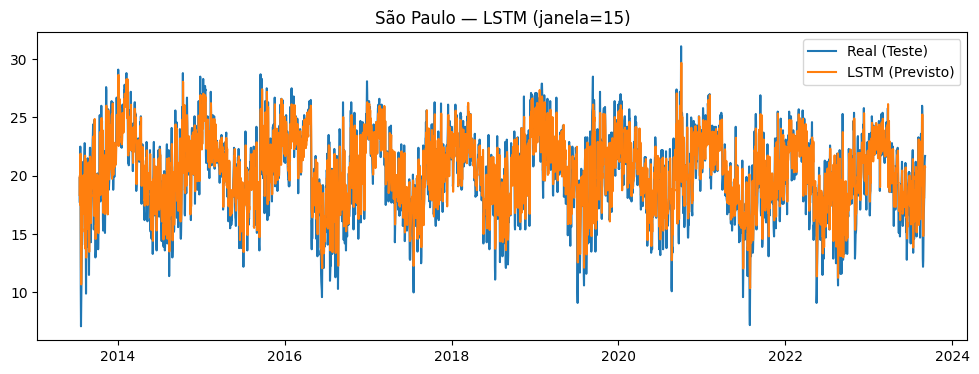

In [39]:
plt.plot(test.index, y_test_inv, label="Real (Teste)")
plt.plot(test.index, preds_inv,  label="LSTM (Previsto)")
plt.title("São Paulo — LSTM (janela=15)")
plt.legend(); plt.show()

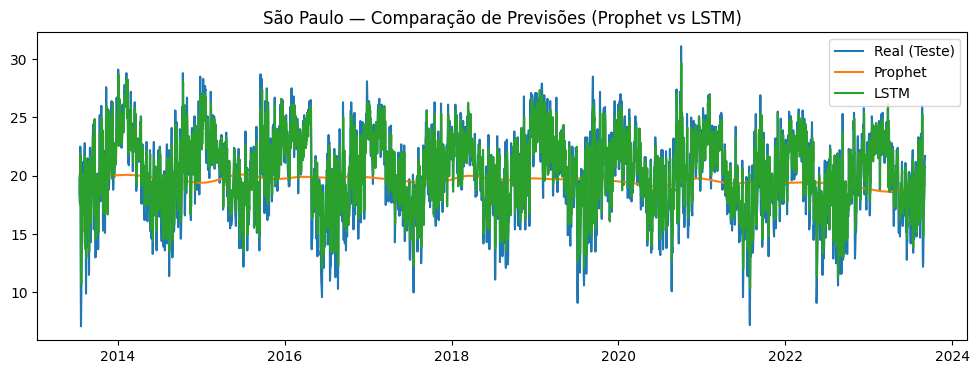

In [40]:
# alinhar ambos na mesma linha do tempo do teste
series_prophet = pd.Series(prophet_res['yhat'].values, index=test.index, name="Prophet")
series_lstm    = pd.Series(preds_inv.ravel(),            index=test.index, name="LSTM")
series_real    = pd.Series(test['avg_temp_c'].values,    index=test.index, name="Real")

plt.plot(series_real,    label="Real (Teste)", linewidth=1.5)
plt.plot(series_prophet, label="Prophet",      linewidth=1.5)
plt.plot(series_lstm,    label="LSTM",         linewidth=1.5)
plt.title("São Paulo — Comparação de Previsões (Prophet vs LSTM)")
plt.legend(); plt.show()

In [41]:
comp = pd.DataFrame({
    "Modelo": ["Prophet", "LSTM"],
    "RMSE (°C)": [rmse_prophet, rmse_lstm],
    "MAE (°C)":  [mae_prophet,  mae_lstm],
}).sort_values("RMSE (°C)")
comp.reset_index(drop=True)

,Modelo,RMSE (°C),MAE (°C)
0,LSTM,1.845824,1.372447
1,Prophet,3.493825,2.855448


Métricas usadas:
- **RMSE (Root Mean Squared Error)**: penaliza mais fortemente grandes erros, útil para temperatura ao destacar desvios grandes.
- **MAE (Mean Absolute Error)**: interpretação direta "em °C" do erro médio absoluto.

Referência clássica:
Hyndman, R. J. & Athanasopoulos, G. (2018). Forecasting: Principles and Practice — capítulo sobre métricas de erro.

Link do dataset:
Global Daily Climate Data (Kaggle): https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data